# Dimensionality Reduction - Text Data

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets, decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap, TSNE, MDS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import ticker
import time
import re
from tqdm import tqdm

import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, UpSampling2D, Conv2DTranspose, Conv2D, MaxPool2D, Flatten, \
                                    Embedding, LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean

import faiss
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import shortest_path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import spacy
from spacy.pipeline.textcat import Config, single_label_cnn_config
from spacy.training.example import Example
from spacy.util import minibatch, compounding

## Standford IMDB

In [2]:
# Define stop words set
stop_words = ENGLISH_STOP_WORDS

# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocessing(text):
    """
    Processes and cleans the input text for natural language processing tasks.

    The function converts text to lowercase, removes apostrophe-s, single-letter abbreviations, 
    and punctuations. It tokenizes the text, lemmatizes tokens, and excludes stop words 
    and non-alphabetical tokens.

    Parameters:
    text (str): The text to preprocess.
    lemmatizer (nltk.stem.WordNetLemmatizer): The lemmatizer to use for processing the text.
    stop_words (set): Set of words to be excluded.

    Returns:
    list: List of lemmatized, non-stop word tokens from the text.
    """
    text = re.sub("<br />", " ", text.lower())
    # lowercase and remove apostrophe-s at end of words
    text = re.sub("'s\\b", " ", text.lower())
    # replace single letters followed by a period with a space
    text = re.sub(r"\b[a-zA-Z]\.", " ", text)
    # remove punctuation (any character that is not a word character)
    text = re.sub(r"[^\w\s]"," ", text)
    # split text into words
    tokens = word_tokenize(text)
    # perform lemmatization on words with only alphabets and remove stop words
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() 
              and lemmatizer.lemmatize(token) not in stop_words]
    return ' '.join(tokens)

# Load and preprocess the IMDB dataset
df = pd.read_csv('IMDB Dataset.csv')

# Apply preprocessing
df['cleaned_text'] = df['review'].apply(preprocessing)
df.head()

,review,sentiment,cleaned_text
0,One of the other reviewers has mentioned that ...,positive,reviewer ha mentioned watching just oz episode...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wa wonderful way spend time hot summer...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...


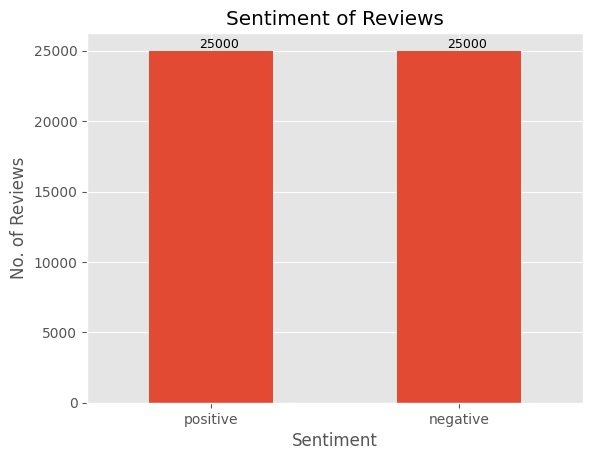

In [3]:
plt.style.use('ggplot')

# Create bar chart
ax = df['sentiment'].value_counts().plot(kind="bar")
# Add value label for bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.2, p.get_height()+200), size=9)
# Add title and labels for x and y axes
plt.xlabel('Sentiment')
plt.xticks(rotation=0)
plt.ylabel('No. of Reviews')
plt.title('Sentiment of Reviews')
plt.show()

In [4]:
# Convert text data into TF-IDF vectors and split data into train and test sets
texts = df['cleaned_text'].values
labels = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['cleaned_text'])
y = labels
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

### PCA

In [5]:
# Standardize the features before applying PCA
scaler = StandardScaler(with_mean=False)
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

100%|█████████████████████████████████████████████| 7/7 [01:48<00:00, 15.53s/it]


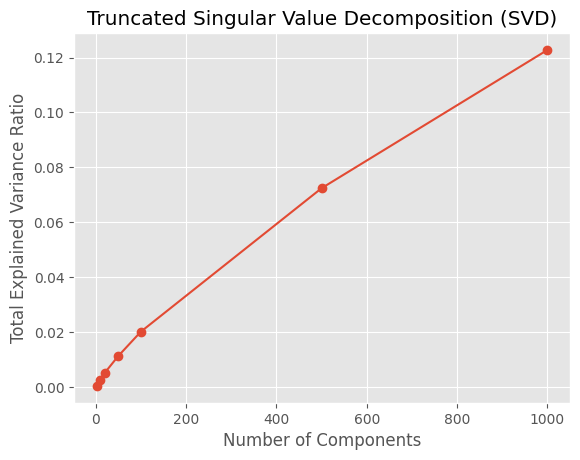

In [15]:
## Perform PCA with various no. of components 
n_components_list = [2, 10, 20, 50, 100, 500, 1000] 
total_variance_ratio = []
for n in tqdm(n_components_list):
    svd = decomposition.TruncatedSVD(n_components=n, random_state=42)
    svd.fit_transform(x_train_scaled)
    total_variance_ratio.append(svd.explained_variance_ratio_.sum())

# Plotting the total explained variance ratio against the number of PC components
plt.plot(n_components_list, total_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Total Explained Variance Ratio')
plt.title('Truncated Singular Value Decomposition (SVD)')
plt.show()

In [16]:
# Apply PCA, we will reduce the dimensions to 100 components for illustration purposes
n_components=2
svd = decomposition.TruncatedSVD(n_components=n, random_state=42)
x_train_svd = svd.fit_transform(x_train_scaled)
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Variance explained by the first {n_components} components: {explained_variance*100:.2f}%")

Variance explained by the first 2 components: 12.28%


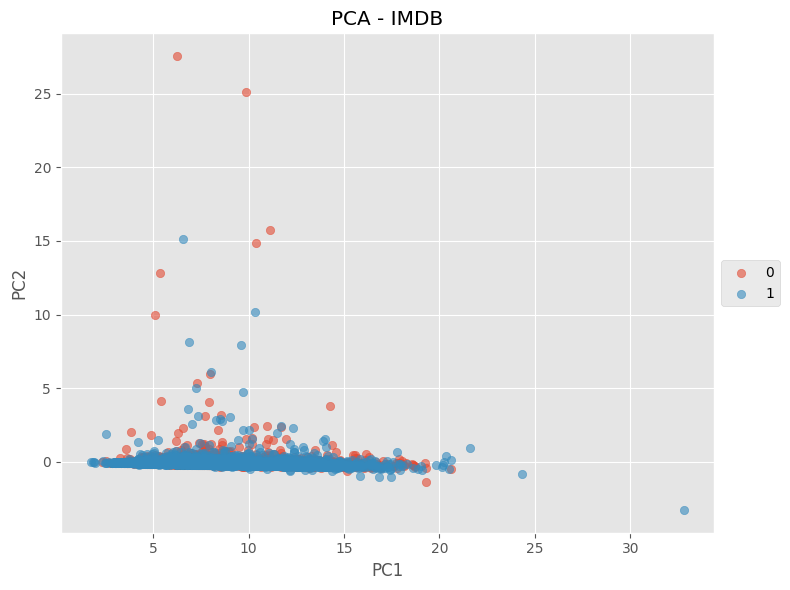

In [18]:
# Define label set and distinct colourmap
unique_labels = set(y_train)

def plot_2d_comparison(x, y, n_data, unique_labels, x_label, y_label, title):
    plt.figure(figsize=(8,6))
    for i in unique_labels:
        plt.scatter(x[:n_data][y[:n_data] == i, 0], 
                    x[:n_data][y[:n_data] == i, 1], 
                    label=i, alpha=0.6)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualise the first two principal components
plot_2d_comparison(x_train_svd, y_train, 10000, unique_labels, 'PC1', 'PC2', 'PCA - IMDB')

### Isomap

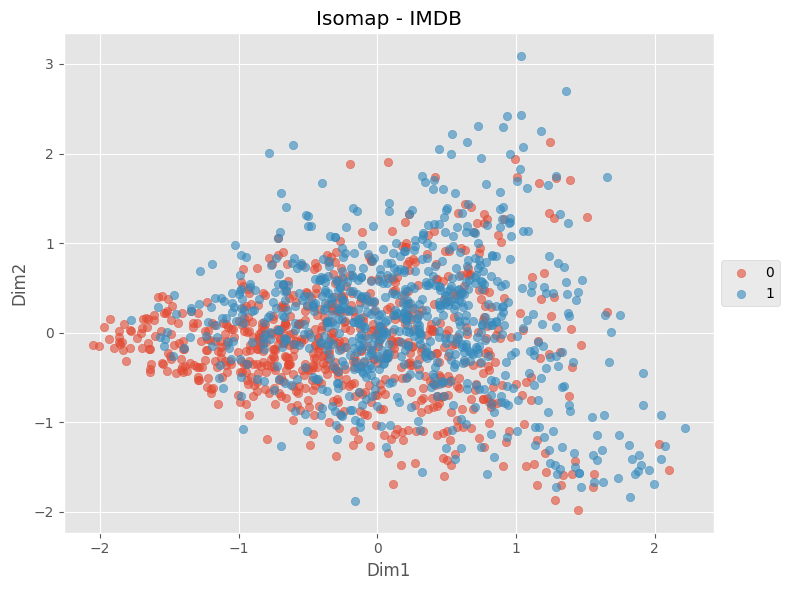

In [11]:
# Reduce the dimensionality of the dataset to two-dimensional using Isomap
isomap_mnist = Isomap(n_components=2, n_neighbors=10) 
# Fit the isomap algorithn using the first 10,000 data points to reduce compute time
x_train_isomap = isomap_mnist.fit_transform(X_train[:10000]) 

# Visualise the 2d representation of the dataset
plot_2d_comparison(x_train_isomap, y_train[:10000], 1500, unique_labels, 
               'Dim1', 'Dim2', 'Isomap - IMDB')

### Geodesic distance + MDS

In [8]:
start_time = time.time()
n_neighbors = 10
data = X_train

# Use FAISS to find approximate nearest neighbors
d = data.shape[1]
faiss_index = faiss.IndexFlatL2(d)
faiss_index.add(data)
distances, indices = faiss_index.search(data, n_neighbors)

# Construct sparse neighborhood graph
n_samples = data.shape[0]
graph = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(1, n_neighbors):  # start from 1 to skip self-loop
        graph[i, indices[i, j]] = distances[i, j]
        graph[indices[i, j], i] = distances[i, j]

graph = csr_matrix(graph)

# Compute geodesic distances using the shortest path algorithm
geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken to run the function: {elapsed_time} seconds")

Time taken to run the function: 2184.48157286644 seconds


In [24]:
# Save the numpy array to a CSV file
np.savetxt("geo_dist_mnist.csv", geodesic_distances, delimiter=",", fmt="%d")

In [9]:
# Load data from CSV file
geodesic_distances = np.loadtxt("geo_dist_mnist.csv", delimiter=",", dtype=np.float32)

# Verify the loaded data
print("Loaded data shape:", geodesic_distances.shape)

Loaded data shape: (60000, 60000)


### t-SNE

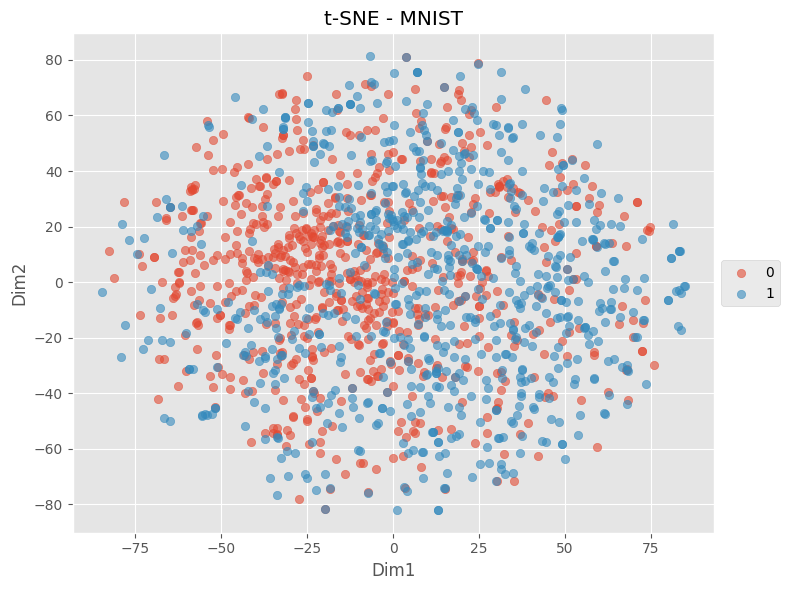

In [12]:
# Reduce the dimensionality of the dataset to two-dimensional using t-SNE
tsne_imdb = TSNE(n_components=2, init='random') 
x_train_tsne = tsne_imdb.fit_transform(X_train[:10000])

# Visualise the 2d representation of the dataset
plot_2d_comparison(x_train_tsne, y_train[:10000], 1500, unique_labels,
               'Dim1', 'Dim2', 't-SNE - MNIST')

### spaCy Sentimental Analysis

In [ ]:
# import random
# from tqdm import tqdm

# # Set seed for reproducibility
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# spacy.util.fix_random_seed(seed)

# # Update train datasest into format required by spaCy
# train_labels =  [{'cats': {'positive': label == 'positive', 'negative': label == 'negative'}} 
#                 for label in y_train]
# train_data = list(zip(X_train, train_labels))

# # Load a spaCy pre-trained model
# nlp = spacy.load("en_core_web_lg")

# # Add a TextCategorizer
# config = Config().from_str(single_label_cnn_config)
# if "textcat" not in nlp.pipe_names:
#      text_cat = nlp.add_pipe('textcat', config=config, last=True)

# # Add labels to the TextCategorizer
# text_cat.add_label("positive")
# text_cat.add_label("negative")

# # Train only the TextCategoriser
# training_excluded_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]
# with nlp.disable_pipes(training_excluded_pipes):
#     optimizer = nlp.create_optimizer()
#     losses = {}
#     for epoch in tqdm(range(150)):
#         batch_sizes = compounding(4.0, 32.0, 1.1)
#         batches = minibatch(train_data, size=batch_sizes)
#         # Iterate through minibatches
#         for batch in batches:
#             texts, annotations = zip(*batch)
#             example = []
#             # Iterate through the reviews in each batch
#             for i in range(len(texts)):
#                 doc = nlp.make_doc(texts[i])
#                 example.append(Example.from_dict(doc, annotations[i]))      
#             # Update the model
#             nlp.update(example, drop=0.5, losses=losses)
            
# # Evaluate model performance on test data
# TP, FP, TN, FN = 0, 0, 0, 0
# for i, result in enumerate(nlp.pipe(X_test)):
#     true_label = y_test[i]
#     predicted_pos_score = result.cats['positive']
#     if predicted_pos_score > 0.5:
#         predicted_label = 'positive'
#     else:
#         predicted_label = 'negative'
#     # Compute true positive, false positive, true negative & false negative
#     if predicted_label == 'positive' and true_label == 'positive':
#         TP += 1
#     elif predicted_label == 'positive' and true_label == 'negative':
#         FP += 1
#     elif predicted_label == 'negative' and true_label == 'negative':
#         TN += 1
#     elif predicted_label == 'negative' and true_label == 'positive':
#         FN += 1

# # Compute accuracy, precision, recall & f1 score
# accuracy = (TP + TN) / (TP + TN + FP + FN)
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)
# f_score = 2 * (precision * recall) / (precision + recall)

# print('Accuracy: {:.1%}'.format(accuracy))
# print('Precision: {:.1%}'.format(precision))
# print('Recall: {:.1%}'.format(recall))
# print('F1 Score: {:.1%}'.format(f_score))

### Autoencoder

In [6]:
# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.50d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding_vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = embedding_vector

In [8]:
# Set seed for reproducibility
seed = 7

# Set the dimensions for input and lower embeddings
input_shape = (28, 28, 1)
encoded_dim = 2

def get_cnn_encoder(input_shape, encoded_dim, dataset, seed=5):
    """
    Define the CNN encoder part of a CNN autoencoder.
    
    Parameters:
    input_shape (tuple): Shape of the input data.
    encoded_dim (int): Dimension of the encoded representation.
    dataset (str): Name of the dataset.
    seed (int): Random seed for weight initialization.
    
    Returns:
    Model: CNN encoder model.
    """
    inputs = Input(shape=(input_shape))
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same', 
               kernel_initializer=GlorotUniform(seed=seed))(inputs)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same', 
               kernel_initializer=GlorotUniform(seed=seed))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(x)
    x = Dropout(0.2)(x)
    encoded = Dense(encoded_dim, kernel_initializer=GlorotUniform(seed=seed))(x)
    cnn_encoder = Model(inputs, encoded, name=f'{dataset}_cnn_encoder')
    return cnn_encoder

def get_cnn_decoder(input_shape, encoded_dim, dataset, seed=5):
    """
    Define the CNN decoder part of a CNN autoencoder.
    
    Parameters:
    input_shape (tuple): Shape of the output data.
    encoded_dim (int): Dimension of the encoded representation.
    dataset (str): Name of the dataset.
    seed (int): Random seed for weight initialization.
    
    Returns:
    Model: CNN decoder model.
    """
    encoded_inputs = Input(shape=(encoded_dim,))
    x = Dense(64, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(encoded_inputs)
    x = Dense(7*7*64, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(x)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same', 
                        kernel_initializer=GlorotUniform(seed=seed))(x)
    decoded = Conv2DTranspose(input_shape[-1], 3, activation='sigmoid', strides=2, padding='same', 
                              kernel_initializer=GlorotUniform(seed=seed))(x)
    cnn_decoder = Model(encoded_inputs, decoded, name=f'{dataset}_cnn_decoder')
    return cnn_decoder
    
def get_cnn_autoencoder(input_shape, encoded_dim, dataset, seed=5):
    """
    Construct the complete CNN autoencoder by combining the CNN encoder and CNN decoder.
    
    Parameters:
    input_shape (tuple): Shape of the input data.
    encoded_dim (int): Dimension of the encoded representation.
    dataset (str): Name of the dataset.
    seed (int): Random seed for weight initialization.
    
    Returns:
    Model: CNN autoencoder model.
    """
    cnn_encoder = get_cnn_encoder(input_shape, encoded_dim, dataset, seed=seed)
    cnn_decoder = get_cnn_decoder(input_shape, encoded_dim, dataset, seed=seed)
    inputs = Input(shape=(input_shape))
    encoded = cnn_encoder(inputs)
    decoded = cnn_decoder(encoded)
    autoencoder = Model(inputs=inputs, outputs=decoded, name=f'{dataset}_cnn_autoencoder')
    return autoencoder

# Build and train the CNN autoencoder for the MNIST dataset
mnist_autoencoder = get_cnn_autoencoder(input_shape, encoded_dim, 'mnist')
mnist_encoder = mnist_autoencoder.get_layer('mnist_cnn_encoder')

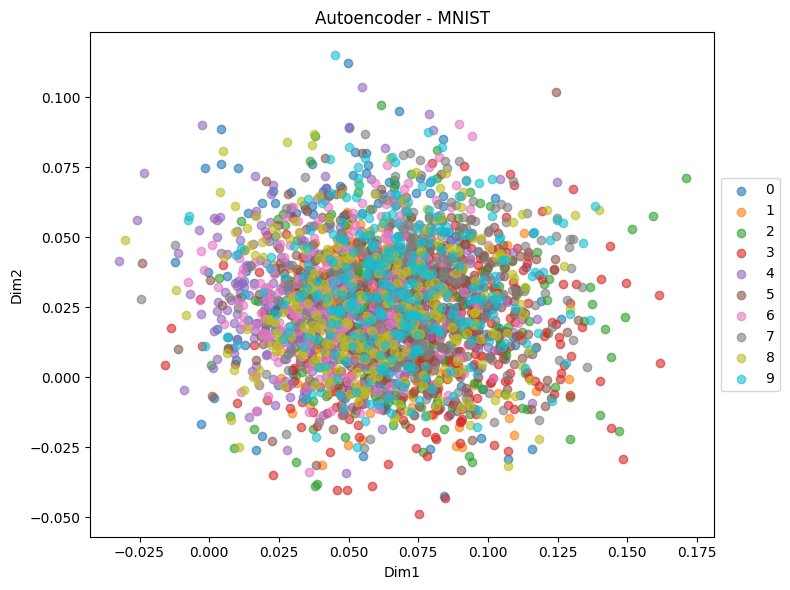

In [9]:
# Compute the encodings after training
untrained_encodings_mnist = mnist_encoder(x_test).numpy()

# Visualise the trained latent encodings
plot_2d_mnist(untrained_encodings_mnist, y_test, 3000, unique_labels, 
               'Dim1', 'Dim2', 'Autoencoder - MNIST')

In [10]:
# Create Dataset objects for train and test sets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test))

# Shuffle and batch the datasets
shuffle_buffer_size = 1000
batch_size = 64
train_dataset = train_dataset.shuffle(shuffle_buffer_size, seed).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create an EarlyStopping callback to terminate training if the validation total loss doesn't immprove after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Compile and fit the model
mnist_autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
history_mnist = mnist_autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=early_stopping, verbose=0)

Final Training Loss: 0.0381, Final Validation Loss: 0.0374


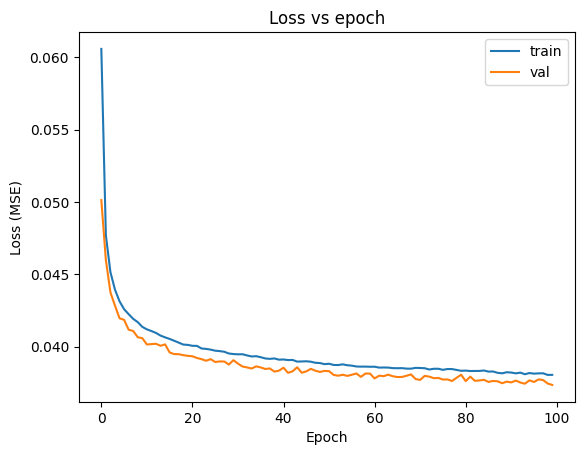

In [11]:
# Print final training and validation loss (MSE)
final_train_loss = history_mnist.history['loss'][-1]
final_val_loss = history_mnist.history['val_loss'][-1]
print(f"Final Training Loss: {final_train_loss:.4f}, Final Validation Loss: {final_val_loss:.4f}")

# Examine the training and validation loss (MSE) over epochs
plt.plot(history_mnist.history['loss'], label='train')
plt.plot(history_mnist.history['val_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Loss vs epoch")
plt.legend()

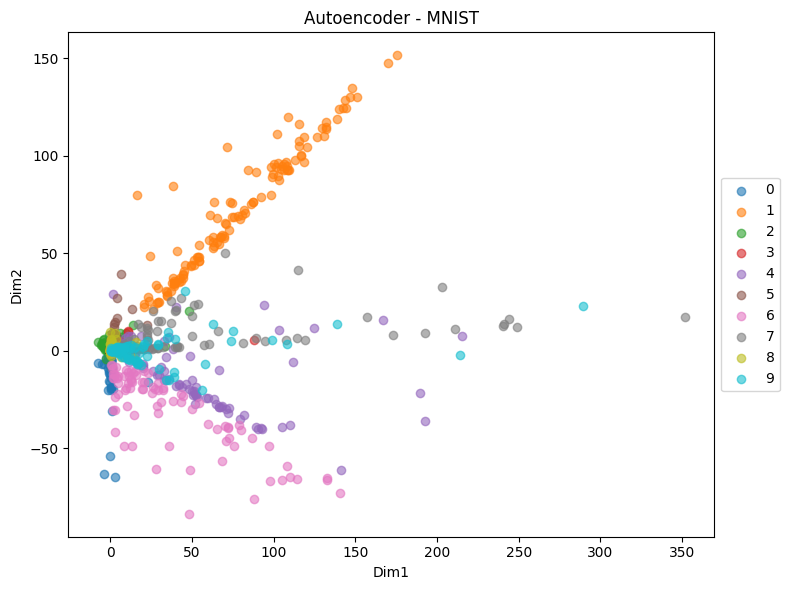

In [12]:
# Compute the encodings after training
trained_encodings_mnist = mnist_encoder(x_test).numpy()

# Visualise the trained latent encodings
plot_2d_mnist(trained_encodings_mnist, y_test, 1000, unique_labels, 
               'Dim1', 'Dim2', 'Autoencoder - MNIST')

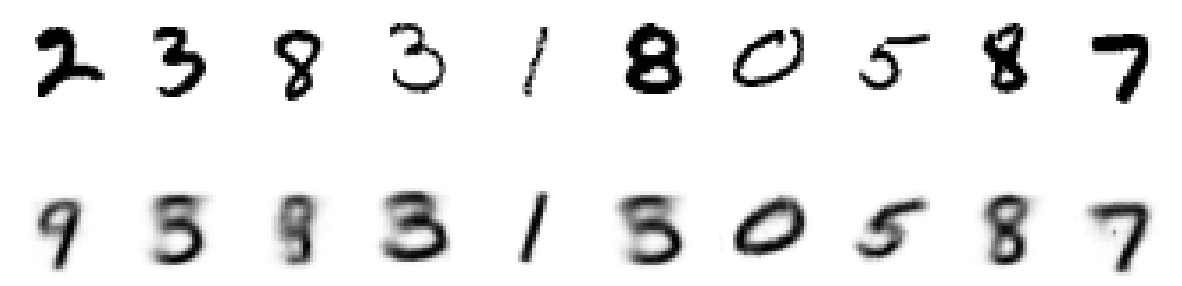

In [13]:
np.random.seed(5)
inx = np.random.choice(x_test.shape[0], 10, replace=False)
reconstructed_mnist_images = mnist_autoencoder(x_test[inx])

f, axs = plt.subplots(2, 10, figsize=(15, 4))
for j in range(10):
    axs[0, j].imshow(x_test[inx][j], cmap='binary')
    axs[1, j].imshow(reconstructed_mnist_images[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')
plt.show()

### GCAE

In [29]:
class GCAETrainer(Model):
    """
    A trainer class for a GCAE that handles model training and evaluation.
    """
    def __init__(self, dataset, input_dim=(None,None,1), embedding_dim=2, n_neighbors=10, alpha=0.01, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.dataset = dataset
        self.n_neighbors = n_neighbors
        self.gcae = get_cnn_autoencoder(self.input_dim, self.embedding_dim, self.dataset)
        self.encoder = self.gcae.get_layer(f'{self.dataset}_cnn_encoder')
        self.alpha = alpha

        # FAISS index and training data
        self.faiss_index = None
        self.neigh_graph = None
        self.train_geo_dist = None
        self.train_geo_dist_max = None
        self.test_geo_dist = None

        # Define the loss metrics to track and log
        self.total_loss_metric = Mean(name='total_loss')
        self.reconstruction_loss_metric = Mean(name='reconstruction_loss')
        self.geodesic_loss_metric = Mean(name='geodesic_loss')

    @property
    def metrics(self):
        """
        Returns a list of metrics used in training and evaluation.
        """
        return [self.total_loss_metric, self.reconstruction_loss_metric, self.geodesic_loss_metric]

    def compute_geodesic_distances(self, data, training=False):
    
        if training:
            
            # Use FAISS to find approximate nearest neighbors
            d = data.shape[1]
            faiss_index = faiss.IndexFlatL2(d)
            faiss_index.add(data)
            self.faiss_index = faiss_index
            distances, indices = faiss_index.search(data, self.n_neighbors)
        
            # Construct sparse neighborhood graph
            n_samples = data.shape[0]
            graph = np.zeros((n_samples, n_samples))
            for i in range(n_samples):
                for j in range(1, self.n_neighbors):  # start from 1 to skip self-loop
                    graph[i, indices[i, j]] = np.sqrt(distances[i, j])
                    graph[indices[i, j], i] = np.sqrt(distances[i, j])          
            graph = csr_matrix(graph)
            self.neigh_graph = graph
        
            # Compute geodesic distances using the shortest path algorithm
            geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)
            geodesic_distances = np.float32(geodesic_distances)
            self.train_geo_dist = geodesic_distances
            self.train_geo_dist_max = np.max(geodesic_distances)
            
        else:

            # Use trained FAISS index to find approximate nearest neighbors
            n_train = self.faiss_index.ntotal
            n_samples = tf.shape(data)[0]
            n_total = n_train + n_samples
            distances, indices = self.faiss_index.search(data, self.n_neighbors)
    
            # Construct sparse neighborhood graph
            graph = np.zeros((n_total, n_total))
            graph[:n_train, :n_train] = self.neigh_graph
            for i in range(n_samples):
                for j in range(1, self.n_neighbors):  # start from 1 to skip self-loop
                    graph[n_train+i, indices[i, j]] = np.sqrt(distances[i, j])
                    graph[indices[i, j], n_train+i] = np.sqrt(distances[i, j])
            graph = csr_matrix(graph)
            
            # Compute geodesic distances using the shortest path algorithm for all data
            geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)
    
            # Extract the geodesic distances matrix for only new data
            geodesic_distances = geodesic_distances[n_train:, n_train:]
            geodesic_distances = np.float32(geodesic_distances)
            self.test_geo_dist = geodesic_distances
            
        return geodesic_distances
    
    def compute_geodesic_loss(self, z, geodesic_distances, batch_indices):
        """
        Computes geodesic distance loss.
        """
        # Calculate the pairwise Euclidean distances in the latent space
        z_distances = tf.norm(z[:, tf.newaxis] - z, axis=2)
        # Calculate the geodesic distance loss
        batch_indices_np = batch_indices.numpy()
        geodesic_distances_batch = geodesic_distances[np.ix_(batch_indices_np, batch_indices_np)]
        # geodesic_distances_batch = tf.gather(tf.gather(geodesic_distances, batch_indices, axis=0), batch_indices, axis=1)
        distance_loss = tf.reduce_mean((z_distances - geodesic_distances_batch) ** 2) / self.train_geo_dist_max
        return distance_loss
        
    def _get_losses(self, x, batch_indices, training=False):
        """
        Computes model losses from inputs.
        """
        reconstructions = self.gcae(x, training=training)
        latent = self.encoder(x)
        # Compute the reconstruction loss
        x = tf.expand_dims(x, axis=-1)
        reconstruction_loss = (
            tf.reduce_mean((x - reconstructions) ** 2)
        )
        # Compute the geodesic loss
        if training:
            geodesic_loss = self.compute_geodesic_loss(z=latent, geodesic_distances=self.train_geo_dist, 
                                                       batch_indices=batch_indices)
        else:    
            geodesic_loss = self.compute_geodesic_loss(z=latent, geodesic_distances=self.test_geo_dist, 
                                                       batch_indices=batch_indices)
        # Cmpute the total loss
        total_loss = reconstruction_loss + self.alpha * geodesic_loss
        return total_loss, reconstruction_loss, geodesic_loss

    def train_step(self, data):
        """
        Performs one training step using a single batch of data.
        """
        x, batch_indices = data
        with tf.GradientTape() as tape:
            total_loss, reconstruction_loss, geodesic_loss = self._get_losses(x, batch_indices, training=True)
        grads = tape.gradient(total_loss, self.gcae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.gcae.trainable_variables))

        # Update loss metrics
        self.total_loss_metric.update_state(total_loss)
        self.reconstruction_loss_metric.update_state(reconstruction_loss)
        self.geodesic_loss_metric.update_state(geodesic_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """
        Evaluates the model using a single batch of data.
        """
        x, batch_indices = data
        total_loss, reconstruction_loss, geodesic_loss = self._get_losses(x, batch_indices, training=False)

        # Update loss metrics
        self.total_loss_metric.update_state(total_loss)
        self.reconstruction_loss_metric.update_state(reconstruction_loss)
        self.geodesic_loss_metric.update_state(geodesic_loss)
        return {m.name: m.result() for m in self.metrics}


# Define the gcae trainer
gcae_trainer = GCAETrainer(input_dim=input_shape, embedding_dim=encoded_dim, n_neighbors=10, dataset='mnist')

# Ensure eager execution
tf.config.run_functions_eagerly(True)

# # Generate Geodesic distance matrix for train and validation data
# train_start_time = time.time()
# train_geo_dist = gcae_trainer.compute_geodesic_distances(X_train, training=True)
# train_end_time = time.time()
# print(f"Time taken to compute geodesic distances for train data: {train_end_time - train_start_time} seconds") # 2393.357335090637 seconds

# # Save the numpy array to a CSV file
# np.savetxt("mnist_train_geo_dist.csv", gcae_trainer.train_geo_dist, delimiter=",", fmt="%d")

# val_start_time = time.time()
# val_geo_dist = gcae_trainer.compute_geodesic_distances(X_test, training=False)
# val_end_time = time.time()
# print(f"Time taken to compute geodesic distances for val data: {val_end_time - val_start_time} seconds") # 3650.7034978866577 seconds

# # Save the numpy array to a CSV file
# np.savetxt("mnist_test_geo_dist.csv", gcae_trainer.test_geo_dist, delimiter=",", fmt="%d")

In [30]:
# Load data from CSV file
train_geo_dist = np.loadtxt("mnist_train_geo_dist.csv", delimiter=",", dtype=np.float32)
val_geo_dist = np.loadtxt("mnist_test_geo_dist.csv", delimiter=",", dtype=np.float32)

# Verify the loaded data
print("Loaded MNIST train geo dist shape:", train_geo_dist.shape)
print("Loaded MNIST test geo dist shape:", val_geo_dist.shape)

Loaded MNIST train geo dist shape: (60000, 60000)
Loaded MNIST test geo dist shape: (10000, 10000)


In [32]:
gcae_trainer.train_geo_dist = train_geo_dist
gcae_trainer.train_geo_dist_max = np.max(train_geo_dist)
gcae_trainer.test_geo_dist = val_geo_dist

In [ ]:
# Convert data to TensorFlow Dataset
batch_size = 64
train_data = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), np.arange(len(x_train))))
train_data = train_data.batch(batch_size)
val_data = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), np.arange(len(x_test))))
val_data = val_data.batch(batch_size)

# Create an EarlyStopping callback to terminate training if the validation total loss doesn't immprove after 10 epochs
early_stopping = EarlyStopping(monitor='val_total_loss', patience=10, mode='min', restore_best_weights=True)

# Train the autoencoder over 100 epochs
gcae_trainer.compile(optimizer='adam')
history_gc_mnist = gcae_trainer.fit(train_data, validation_data=val_data, epochs=100, callbacks=early_stopping, verbose=0)

# Print final training and validation loss (MSE)
final_train_loss = history_gc_mnist.history['total_loss'][-1]
final_val_loss = history_gc_mnist.history['val_total_loss'][-1]
print(f"Final Training Loss: {final_train_loss:.4f}, Final Validation Loss: {final_val_loss:.4f}")

# Examine the training and validation loss (MSE) over epochs
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(history_gc_mnist.history['total_loss'], label='train')
plt.plot(history_gc_mnist.history['val_total_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Total Loss (MSE + Geodesic Loss)")
plt.title("Total Loss vs epoch")
plt.legend()

plt.subplot(1,3,2)
plt.plot(history_gc_mnist.history['reconstruction_loss'], label='train')
plt.plot(history_gc_mnist.history['val_reconstruction_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Reconstruction Loss vs epoch")
plt.legend()

plt.subplot(1,3,3)
plt.plot(history_gc_mnist.history['geodesic_loss'], label='train')
plt.plot(history_gc_mnist.history['val_geodesic_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Geodesic Loss")
plt.title("Geodesic Loss vs epoch")
plt.legend()
plt.show()

In [ ]:
mnist_gc_encoder = gcae_trainer.gcae.get_layer('mnist_cnn_encoder')

# Compute the encodings after training
trained_encodings_gc_mnist = mnist_gc_encoder(x_test).numpy()

# Visualise the trained latent encodings
plot_2d_mnist(trained_encodings_gc_mnist, y_test, 1000, unique_labels, 
               'Dim1', 'Dim2', 'GCAE - MNIST')

In [ ]:
mnist_gc_autoencoder = gcae_trainer.gcae

np.random.seed(5)
inx = np.random.choice(x_test.shape[0], 10, replace=False)
reconstructed_mnist_images_gc = mnist_gc_autoencoder(x_test[inx])

f, axs = plt.subplots(2, 10, figsize=(15, 4))
for j in range(10):
    axs[0, j].imshow(x_test[inx][j], cmap='binary')
    axs[1, j].imshow(reconstructed_mnist_images_gc[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')
plt.show()

### Logistic Regression

In [ ]:
# Train logistic classifier using original data
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Validate accuracy using test data
pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)
print(acc)

In [ ]:
seed = 42
input_shape = (28, 28, 1)
dims = [2, 10, 20, 50, 100]
accs = []

for d in dims:
    # Build and train the CNN autoencoder for the MNIST dataset
    mnist_autoencoder = get_cnn_autoencoder(input_shape, d, 'mnist')
    mnist_encoder = mnist_autoencoder.get_layer('mnist_cnn_encoder')
    mnist_autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
    history_mnist = mnist_autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=early_stopping, verbose=0)

    # Generate encodings for train data
    trained_mnist_encodings = mnist_encoder(x_train).numpy()

    # Train logistic classifier using standard autoencoder's embeddings
    model = LogisticRegression(random_state=seed, max_iter=1000)
    model.fit(trained_mnist_encodings, y_train)

    # Generate encodings for test data
    predicted_mnist_encodings = mnist_encoder(x_test).numpy()
    
    # Validate classification accuracy on test data
    pred = model.predict(predicted_mnist_encodings)
    acc = accuracy_score(y_test, pred)
    accs.append(acc)
    print(f'Accuracy with {d} dimensions: {acc}')

In [ ]:
seed = 42
input_shape = (28, 28, 1)
dims = [2, 10, 20, 50, 100]
accs = []

for d in dims:
    # Build and train the CNN autoencoder for the MNIST dataset
    mnist_autoencoder = get_cnn_autoencoder(input_shape, d, 'mnist')
    mnist_encoder = mnist_autoencoder.get_layer('mnist_cnn_encoder')
    mnist_autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
    history_mnist = mnist_autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=early_stopping, verbose=0)

    # Generate encodings for train data
    trained_mnist_encodings = mnist_encoder(x_train).numpy()

    # Train logistic classifier using standard autoencoder's embeddings
    model = LogisticRegression(random_state=seed, max_iter=1000)
    model.fit(trained_mnist_encodings, y_train)

    # Generate encodings for test data
    predicted_mnist_encodings = mnist_encoder(x_test).numpy()
    
    # Validate classification accuracy on test data
    pred = model.predict(predicted_mnist_encodings)
    acc = accuracy_score(y_test, pred)
    accs.append(acc)
    print(f'Accuracy with {d} dimensions: {acc}')